In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
def read_out_tr(out_filename):
    col = ["events", "time", "from_node", "to_node", "pkt_type", "pkt_size", "flags", "fid", "src_addr", "dst_addr", "seq_num", "pkt_id"]
    df = pd.read_csv(out_filename, sep = ' ', header = None)
    df.columns = col
    return df

def get_tcp_packets(df):
    df_out = df.loc[df["pkt_type"].isin(["tcp"])]
    return df_out

def parse_trace(file):
    col = ["tmp_pkts", "flow duration", "fin_fid", "rtt times", \
               "group_id", "Tw_", "Tp_", "Np_", "?1", "?2", "?3", "?4", "?5", "Average rate", "start time"]
    df = pd.read_csv(file, sep = ' ', header = None)
    df.columns = col
    df["Normalized FCT"] = 40 * 1e9  / df["Average rate"]
    return df

def humanbytes(B):
    B = float(B)
    KB = float(1000)
    MB = float(KB ** 2)
    GB = float(KB ** 3)
    TB = float(KB ** 4) 

    if B < KB:
        return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
    elif KB <= B < MB:
        return '{0:.2f} KB'.format(B/KB)
    elif MB <= B < GB:
        return '{0:.2f} MB'.format(B/MB)
    elif GB <= B < TB:
        return '{0:.2f} GB'.format(B/GB)
    elif TB <= B:
        return '{0:.2f} TB'.format(B/TB)

def dropped_pkt(tcp_pkt):
    dropped_pkt_id = (tcp_pkt['events'] == 'd')
    dropped_pkt = tcp_pkt[dropped_pkt_id]
    return dropped_pkt  
    
def plot_one_end2end_drop_flowsize(out_filename, flow_size, tracefile, alg):
    raw_data = read_out_tr(out_filename)
    tcp_pkts = get_tcp_packets(raw_data)
    drop_tcp_pkts = dropped_pkt(tcp_pkts)
    drop_grouped = drop_tcp_pkts.groupby('fid')
    fid_drop_cnt = drop_grouped.nunique()['pkt_id']
    trace_df = parse_trace(tracefile)
    trace_df['flow_drop'] = trace_df["fin_fid"].apply(lambda x: 0 if x not in fid_drop_cnt else fid_drop_cnt[int(x)])
    flow_drop = trace_df[['tmp_pkts', 'fin_fid', 'flow_drop']]
    cate=pd.cut(flow_drop["tmp_pkts"], flow_size, labels=flow_size[:-1])
    drop_average = []
    for label in flow_size[:-1]:
        seg_flow_drop = flow_drop[cate == label]
        drop_average.append(seg_flow_drop.mean()['flow_drop'])
    
    print("Avg_pktdrop of " + alg + ": ")
    print(drop_average)
    plt.plot([humanbytes(i*1500) for i in flow_size[:-1]], drop_average, label=alg)

def plot_end2end_drop_flowsize(flow_size, algs):
    #directory = "/home/ovs2/eval/tcp_random_pair_32host/diff_host_4pods/4host_FID/out_tr/4p4h1000f/"
    directory = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/tcp_random_pair_32host/diff_host_4pods/4host_FID/out_tr/4p4h1000f/"
    plt.figure(figsize=(18,5))
    plt.figure(figsize=(18,5))
    plt.xlabel('flow size')
    plt.ylabel('drop average(count)')
    plt.title("drop average at load 0.9")
    for alg in algs:
        filename = '4p4h1000f_'+alg+'_out.tr'
        #tracefile = "/home/ovs2/eval/tcp_random_pair_32host/diff_host_4pods/4host_FID/tcp-incast-"+alg+"/tcp_flow_1000_0.9_Topology-4hosts-4pods-random.tcl.tr"
        tracefile = "/Users/peixuangao/Documents/NYU/Project/NS2/Hyline/Gearbox-Hyline/data/portland/tcp_random_pair_32host/diff_host_4pods/4host_FID/tcp-incast-"+alg+"/tcp_flow_1000_0.9_Topology-4hosts-4pods-random.tcl.tr"
        plot_one_end2end_drop_flowsize(directory+filename, flow_size, tracefile, alg)
    plt.legend()
    plt.show()
    
    

Avg_pktdrop of HRCC: 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan]
Avg_pktdrop of AFQ10: 
[0.0, 0.0, 0.0, 0.0, 0.0, 2.8524590163934427, 49.71153846153846, 63.767676767676768, 65.579545454545453, 71.775000000000006, 100.39473684210526, nan]
Avg_pktdrop of AFQ100: 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan]
Avg_pktdrop of AFQ1000: 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan]
Avg_pktdrop of AFQ10unlim: 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan]
Avg_pktdrop of DropTail: 
[0.054545454545454543, 0.16981132075471697, 0.13186813186813187, 0.042105263157894736, 0.7142857142857143, 1.4754098360655739, 14.35576923076923, 29.505050505050505, 44.488636363636367, 53.987499999999997, 93.65789473684211, nan]


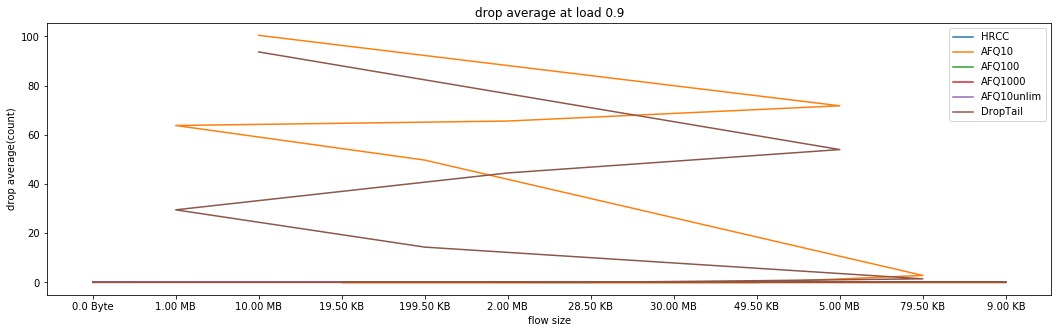

In [3]:
#algs = ['HRCC', 'AFQ10', 'AFQ100', 'AFQ1000', 'AFQ10unlim', 'BDPDropTail', 'DropTail', 'LargeDropTail']
algs = ['HRCC', 'AFQ10', 'AFQ100', 'AFQ1000', 'AFQ10unlim', 'DropTail']
flow_size=[0, 6, 13, 19, 33, 53, 133, 667, 1333, 3333, 6667, 20000, float('inf')]
plot_end2end_drop_flowsize(flow_size, algs)

In [4]:
#Avg_pktdrop of HRCC: 
drop_hrcc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]
#Avg_pktdrop of AFQ10: 
drop_afq10 = [0.0, 0.0, 0.0, 0.0, 0.0, 2.8524590163934427, 49.71153846153846, 63.767676767676768, 65.579545454545453, 71.775000000000006, 100.39473684210526, 0]
#Avg_pktdrop of AFQ100: 
drop_afq100 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]
#Avg_pktdrop of AFQ1000: 
drop_afq1000 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]
#Avg_pktdrop of AFQ10unlim: 
drop_afq10unlim = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0]
#Avg_pktdrop of DropTail: 
drop_droptail = [0.054545454545454543, 0.16981132075471697, 0.13186813186813187, 0.042105263157894736, 0.7142857142857143, 1.4754098360655739, 14.35576923076923, 29.505050505050505, 44.488636363636367, 53.987499999999997, 93.65789473684211, 0]